In [1]:
import keras as k
import keras.backend as K
import numpy as np 
from keras.layers import *
from keras.models import Sequential, Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import cv2
import shutil
import pickle

os_base='C:/Users/Alan/Desktop/Bilab/Bilab/WevearBird/similar_fabric/'

#keras == 2.6.0
#tensorflow == 2.6.0

#儲存讀檔且轉換後images
x_train_images =[]
y_train_images=[]
x_test_images=[]
y_test_images=[]

#規範深度學習參數
batch = 15
img_size = 128
num_train_per_class = 1
n_epochs = 40

data_file='fabric_data/'

#定義image argumentation 參數
#rotation_range 為旋轉、channel_shift_range為色彩偏移、horizontal_flip = 水平翻轉
datagen = ImageDataGenerator(rotation_range=0.2, width_shift_range=0.2, 
height_shift_range=0.2,channel_shift_range = 5, horizontal_flip=True)


In [5]:
# image argumentation
'''
img: 欲argumentation的圖檔
num: 生成多少圖 (int)
'''
def img_argu(img,num):
    arg_img_list = [] #用以儲存argumentation後產生的圖片
    datagen.fit(np.expand_dims(img, 0))
    for x, val in zip(datagen.flow(np.expand_dims(img, 0),                    #image we chose
          save_to_dir=os_base+'temp',     #暫存
          save_prefix='aug',        # it will save the images as 'aug_0912' some number for every new augmented image
          save_format='jpg'),range(num)):     # here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
        pass
    for arg in os.listdir(os_base+'temp'):
        arg_img= cv2.imread(os_base+'temp/'+arg)
        arg_img = cv2.cvtColor(arg_img, cv2.COLOR_BGR2RGB)
        arg_img_list.append(arg_img)
    os.remove(os_base+'temp/'+arg)
    
    return arg_img_list

In [6]:
# 建構triplets 資料集(可參考，simese研究方法與結果.pptx)
'''
dataset: 訓練資料集 x_train_images
label: 類別答案 y_train_images
sample_per_class 指定每一類別中有多少組sample，每一個sample都包含(anchor, positive,negative)
'''
def generate_triplets(dataset, label, sample_per_class=10):
  x, y = None, None
  for i in label:
    #定位相似布料 positive 的位置
    pos_indices = np.argwhere(label == i)[:,0]
    #定位非相似布料 negative 的位置
    neg_indices = np.argwhere(label != i)[:,0]

    #隨機選出10個布料作為anchor
    choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_anchor = pos_indices[choice_anchor]

    #隨機選出10個布料作為positive
    choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_pos = pos_indices[choice_pos]

    #隨機選出10個布料作為negative
    choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=False)
    choice_neg = neg_indices[choice_neg]

    #存為dataset
    sub_x_anc = dataset[choice_anchor]
    sub_x_pos = dataset[choice_pos]
    sub_x_neg = dataset[choice_neg]
      
    #將選出的anchor,positve,negative組合成triplet dataset     
    if(x is None):
      x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
      y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
    else:
      x[0] = np.vstack((x[0], (sub_x_anc)))
      x[1] = np.vstack((x[1], (sub_x_pos)))
      x[2] = np.vstack((x[2], (sub_x_neg)))

      y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
      y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
      y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
    
  return x, y


In [21]:
#讀取相似布料訓練資料集，並拆分為訓練與測試資料集，再對訓練資料集進行argumentation
for i in os.listdir(os_base+data_file):
    #img_list中為同一類布料
    img_list = os.listdir(os_base+data_file+i)
    if i != '.ipynb_checkpoints':
        #從每個類別隨機指定2張圖片為測試資料
        rand = np.random.choice(img_list,2,False)
        for t in img_list:
            img = cv2.imread(os_base+data_file+i+'/'+t)
            #降低畫質並放大紋路，以利深度學習分析
            img = cv2.resize(img, (1000, 1000))
            img = img[256:512,256:512]
            img = cv2.resize(img, (img_size, img_size))
            
            #轉為灰階，以利深度學習分析
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
            
            #若為測試資料rand = 0，將圖檔陣列存至x_test_images，類別名稱存至y_test_images
            if t == rand[0]:
                x_test_images.append(img)
                y_test_images.append(i)
            #若為訓練資料rand = 1，將圖檔陣列存至x_test_images，類別名稱存至y_test_images
            else:
                if t == rand[1]:
                    x_test_images.append(img)
                    y_test_images.append(i)
                x_train_images.append(img)
                y_train_images.append(i)
                
                #對訓練資料進行image argumentation 以增加訓練資料量
                arg_img_list =img_argu(img,5)
                
                x_train_images = x_train_images + arg_img_list
                for j in range(len(arg_img_list)):
                    y_train_images.append(i)
                

# #將圖片陣列儲存，以後就不用重複花時間argumention和resize
# y_train_images = np.array(y_train_images).flatten()
# np.save(os_base +'fabric_array/x_train_array', x_train_images)
# np.save(os_base +'fabric_array/y_train_array', y_train_images)

# #x_test_images = np.expand_dims(x_test_images, 3)
# y_test_images = np.array(y_test_images).flatten()
# np.save(os_base +'fabric_array/x_test_array', x_test_images)
# np.save(os_base +'fabric_array/y_test_array', y_test_images)

In [7]:
# #讀取之前曾經儲存過的圖片陣列
# x_train_images = np.load(os_base +'fabric_array/x_train_array.npy')
# y_train_images = np.load(os_base +'fabric_array/y_train_array.npy')

# x_test_images = np.load(os_base +'fabric_array/x_test_array.npy')
# y_test_images = np.load(os_base +'fabric_array/y_test_array.npy')


In [ ]:
#建立triplet dataset
train_x, train_y = generate_triplets(x_train_images, y_train_images,18)

# print(train_x[0].shape)

# #儲存triplet dataset，節省重複處理時間
# open_file = open(os_base+'triplet/train_x.txt', "wb")
# pickle.dump(train_x, open_file)
# open_file.close()

# open_file = open(os_base+'triplet/train_y.txt', "wb")
# pickle.dump(train_y, open_file)
# open_file.close()

In [ ]:
# #開啟上次儲存的triplet資料集
# open_file = open(os_base+'triplet/train_x.txt', "rb")
# train_x = pickle.load(open_file)
# open_file.close()

# open_file = open(os_base+'triplet/train_y.txt', "rb")
# train_y = pickle.load(open_file)
# open_file.close()

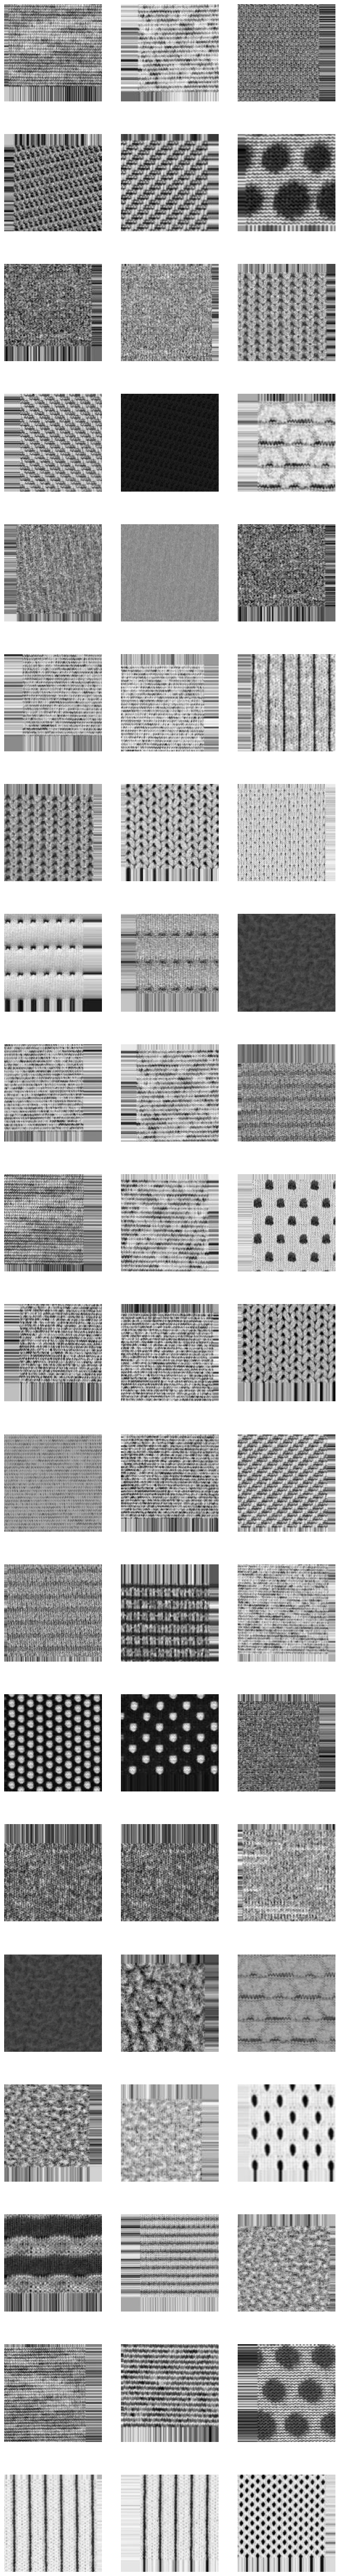

In [12]:
#視覺化 triplet dataset
def visualize_data(data, n):
    n = min(len(data[0]), n)
    random_choices = np.random.choice(len(data[0]),n, replace=False)
    fig, ax = plt.subplots(n, 3,figsize=(10,80))
    anc, pos, neg = data
    for i,ch in enumerate(random_choices):
        ax[i, 0].imshow(np.squeeze(anc[ch] ))
        ax[i, 1].imshow(np.squeeze(pos[ch] ))
        ax[i, 2].imshow(np.squeeze(neg[ch] ))
        
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
    
    plt.show()

visualize_data(train_x, 20)

# simese model 建構
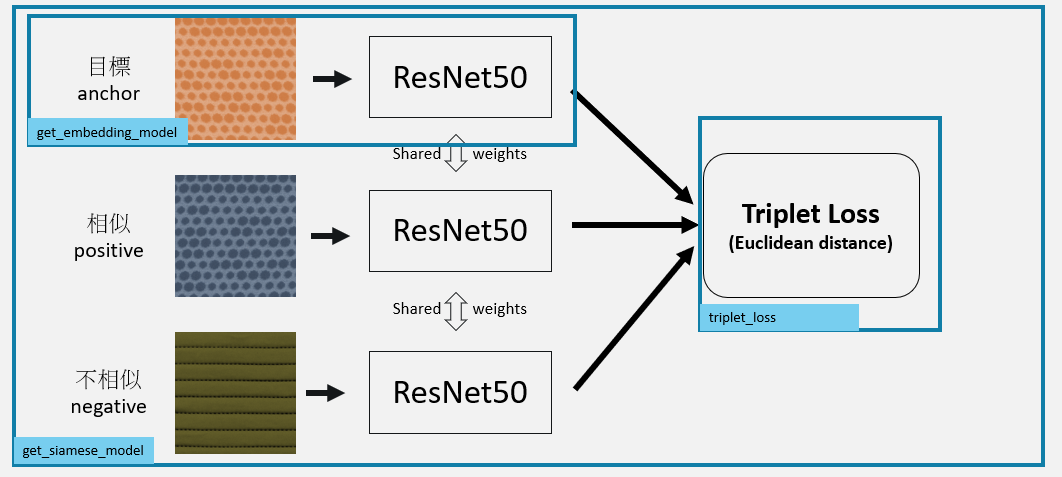

In [4]:
#triplet_loss function 相關計算原理可參考 https://caicaijason.github.io/2019/12/05/triplet_loss%E8%A7%A3%E6%9E%90/
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    # cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
    # positive_distance = 1000*cosine_similarity(anchor, positive)
    # negative_distance = 1000*cosine_similarity(anchor, negative)
    
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = - positive_distance + negative_distance 
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)

#建構單一特徵值萃取model，以keras pretrain的Resnet50 imagenet 為基礎
def get_embedding_model(input_shape, embedding_dim):
    
    model=tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False, pooling='max', input_tensor=Input(shape=(img_size, img_size, 3)))
    
    print(model.summary())
    
    
    return model
        
#將多個get_embedding_model 連接組成siamese model
def get_siamese_model(input_shape, triplet_margin=.3, embedding_dim=50):
    """
        Model architecture
    """
    
    # Define the tensors for the triplet of input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    
    # Convolutional Neural Network (same from earlier)
    embedding_model = get_embedding_model(input_shape, embedding_dim)
    
    # Generate the embedding outputs 
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [encoded_anchor, encoded_positive, encoded_negative]
    
    # Connect the inputs with the outputs
    siamese_triplet = Model(inputs=inputs,outputs=outputs)
    
    siamese_triplet.add_loss((triplet_loss(outputs, dist='euclidean', margin='maxplus')))
    
    # return the model
    return embedding_model, siamese_triplet

# #cosine similarity 計算方式
# def cosine_similarity(x,y):
#     x = K.l2_normalize(x, -1)
#     y = K.l2_normalize(y, -1)
#     s = K.mean(x * y, axis=-1, keepdims=False) * 10
#     return s


(14112, 128, 128, 3)


In [5]:
#train 
embedding_model, siamese_triplet = get_siamese_model((img_size,img_size,3), triplet_margin=.3, embedding_dim=150)
siamese_triplet.compile(loss=None, optimizer=Adam(0.0001))
history = siamese_triplet.fit(x=train_x, shuffle=True, batch_size=batch, epochs=5)
#儲存model
siamese_triplet.save(os_base+'model/my_model.h5')
embedding_model.save(os_base+'model/my_model_emb.h5')

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Epoch 1/5


ResourceExhaustedError:  OOM when allocating tensor with shape[20,128,16,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/resnet50/conv3_block1_1_conv/Conv2D_1 (defined at <ipython-input-5-ee0eebb5ce27>:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_23522]

Function call stack:
train_function


# 檢驗
觀察以訓練出的特徵值萃取模型進行kmeans 分類的準確率

In [5]:
from keras.models import load_model
from sklearn.neighbors import KNeighborsClassifier
#evaluation

#重新先前訓練的讀取特徵值萃取model
embedding_model = load_model(os_base+'model/Res_model_emb_f.h5')
#讀取train data的特徵值
train_embeds = embedding_model.predict(np.vstack((train_x[0], train_x[1], train_x[2])))
target = np.hstack((train_y[0], train_y[1], train_y[2]))

#建構kmeans
def fit_nearest_neighbor(img_encoding, img_class, algorithm='ball_tree'):
      classifier = KNeighborsClassifier(n_neighbors=3, algorithm=algorithm)
      classifier.fit(img_encoding, img_class)
      return classifier
classifier = fit_nearest_neighbor(train_embeds, target)

#獲取test data 的特徵值
train_embeds = embedding_model.predict(x_test_images)
#將test的特徵值帶入kmeans分類
test_pred = classifier.predict(train_embeds)

0.9047619047619048
accuracy score: 0.9047619047619048


<Figure size 7200x7200 with 0 Axes>

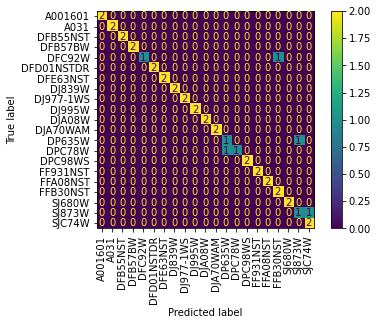

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.classification import accuracy_score
import seaborn as sns 

#計算準確率
print("accuracy score:", accuracy_score(y_test_images, test_pred))

#畫confusion matrix
cm = confusion_matrix(y_test_images, op)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
plt.figure(figsize=(100, 100))
disp.plot()
plt.xticks(rotation=90)
plt.show()